# Importing required libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import DateType, IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, lag, mean

# The code for class for processing of Stock Data

In [38]:
class StocksDataProcessing:
    def __init__(self):
        self.spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate() 
        self.df = None
        
    def ReadData(self, file_path, file_type, schema={}):
        file_location = file_path
        delimiter = ''
        if file_type == 1:
            file_type='csv'
            delimiter=','
        else:
            file='excel'
            delimiter=','
        
        # CSV options
        infer_schema = "true"
        first_row_is_header = "true"
        delimiter = ","
        
        # The applied options are for CSV files. For other file types, these will be ignored.
        if len(schema)>0:    
            self.df = self.spark.read.format(file_type).option("header", first_row_is_header).schema(schema).load(file_location)
        else:
            self.df = self.spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header).load(file_location)
        return self.df
    
    def show_sample_rows(self,first=True):
        if first==True:
            self.df.show(n=40)
        else:
            #data_frame = self.df.toPandas()
            tail = self.df.tail(40)
            print(tail)
    
    def NoObservation(self):
        return self.df.count()
    
    def Period(self):
        df2 = self.df.select((self.df.Date.cast(DateType())).alias('Date')) 
        forEntireRangeWindow = Window.orderBy("Date").rowsBetween(Window.currentRow, Window.currentRow)
        df2 = df2.dropna()
        date_max = df2.agg({"Date": "max"}).collect()[0][0]
        date_min = df2.agg({"Date": "min"}).collect()[0][0]
        return int((date_max-date_min).days/self.NoObservation())
    
    def DescStats(self):
        self.df.describe().show()
        
    def N_Na_Column(self):
        self.df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in self.df.columns]).show()
    
    def MovingAverage(self, view_by="week"):
        forMovingAvgWindow=None
        if view_by=="week":
            forMovingAvgWindow = Window.orderBy("Date").rowsBetween(Window.currentRow-3, Window.currentRow+3)
        elif view_by=="month":
            forMovingAvgWindow = Window.orderBy("Date").rowsBetween(Window.currentRow-15, Window.currentRow+14)
        elif view_by=="year":
            forMovingAvgWindow = Window.orderBy("Date").rowsBetween(Window.currentRow-182, Window.currentRow+182)
        MovingAvgDF = self.df[['Date', 'Open', 'Close']]
        MovingAvgDF = MovingAvgDF.withColumn("open_avg", round(avg('open').over(forMovingAvgWindow), 2))
        MovingAvgDF.show()
        
    def MovingReturn(self, time_period="Weekly"):
        df2 = self.df.select((self.df.Open.cast(FloatType())).alias('Open'), (self.df.Date.cast(DateType())).alias('Date')) 
        forMovingReturnWindow = Window.orderBy("Date")
        if time_period=='Week':
            MovingReturn_df = df2.withColumn("Open_lag",lag("Open",6).over(forMovingReturnWindow))
        elif time_period=='Month':
            MovingReturn_df = df2.withColumn("Open_lag",lag("Open",29).over(forMovingReturnWindow))
        elif time_period=='Year':
            MovingReturn_df = df2.withColumn("Open_lag",lag("Open",364).over(forMovingReturnWindow))        
        MovingReturn_df = MovingReturn_df.withColumn("Return_df", MovingReturn_df["Open"]/MovingReturn_df["Open_lag"]-1)
        MovingReturn_df.show()
        
    def PriceChange(self, time_period="Weekly"):
        df2 = self.df.select((self.df.Open.cast(FloatType())).alias('Open'), (self.df.Close.cast(FloatType())).alias('Close'), (self.df.Date.cast(DateType())).alias('Date')) 
        forMovingReturnWindow = Window.orderBy("Date")
        if time_period=='Week':
            MovingReturn_df = df2.withColumn("Open_lag",lag("Open",6).over(forMovingReturnWindow))
        elif time_period=='Month':
            MovingReturn_df = df2.withColumn("Open_lag",lag("Open",29).over(forMovingReturnWindow))
        elif time_period=='Year':
            MovingReturn_df = df2.withColumn("Open_lag",lag("Open",364).over(forMovingReturnWindow))        
        MovingReturn_df = MovingReturn_df.withColumn("Price_Change",MovingReturn_df["Close"]-MovingReturn_df["Open_lag"]-1)
        MovingReturn_df.show()
        
    def DailyReturn(self):     
        Return_df = self.df.select((self.df.Open.cast(FloatType())).alias('Open'), (self.df.Close.cast(FloatType())).alias('Close'), (self.df.Date.cast(DateType())).alias('Date'))
        Return_df = Return_df.withColumn("Return_df", Return_df["Close"]/Return_df["Open"]-1)
        Return_df.show()
    
    def AvgDailyReturn(self):     
        Return_df = self.df.select((self.df.Open.cast(FloatType())).alias('Open'), (self.df.Close.cast(FloatType())).alias('Close'), (self.df.Date.cast(DateType())).alias('Date'))
        Return_df = Return_df.withColumn("Return_df", Return_df["Close"]/Return_df["Open"]-1)
        return Return_df.agg({"Return_df": "mean"}).collect()[0][0]
    
    def AvgDailyReturn_Period(self, time_period):
        df2 = self.df.select((self.df.Open.cast(FloatType())).alias('Open'), (self.df.Close.cast(FloatType())).alias('Close'), (self.df.Date.cast(DateType())).alias('Date')) 
        forMovingReturnWindow = Window.orderBy("Date")
        Return_df = None
        if time_period=='Week':
            Return_df = df2.withColumn("Open_lag",lag("Open",6).over(forMovingReturnWindow))
        elif time_period=='Month':
            Return_df = df2.withColumn("Open_lag",lag("Open",29).over(forMovingReturnWindow))
        elif time_period=='Year':
            Return_df = df2.withColumn("Open_lag",lag("Open",364).over(forMovingReturnWindow))        
        Return_df = Return_df.withColumn("Return_df", Return_df["Close"]/Return_df["Open_lag"]-1)
        return Return_df.agg({"Return_df": "mean"}).collect()[0][0]
    
    def Correlation(self, Stock1):
        Stock1 = Stock1.select((Stock1.Open.cast(FloatType())).alias('Open_1'), (Stock1.Date.cast(DateType())).alias('Date')) 
        Stock2 = self.df.select((self.df.Open.cast(FloatType())).alias('Open_2'), (self.df.Date.cast(DateType())).alias('Date')) 
        Stock = Stock1.join(Stock2,Stock1.Date ==  Stock2.Date,"inner")
        return Stock.corr('Open_1', 'Open_2')
    
    def Show_Trend(self):
        from matplotlib import pyplot as plt
        Stock = self.df.select((self.df.Open.cast(FloatType())).alias('Open'), (self.df.Date.cast(DateType())).alias('Date')) 
        Stock = Stock.toPandas()
        plt.plot(Stock['Date'], Stock['Open'])
        plt.show()

# The Example for using each of the functions

## Reading the data

In [32]:
stocks = StocksDataProcessing()
stocks.ReadData("D:\\fiverr\\spark, pyspark, mapreduce, hadoop, azure and hive\\guidifleh\\drive-download-20240227T130606Z-001\\AMAZON.csv", 1, {})

DataFrame[Date: string, High: double, Low: double, Open: double, Close: double, Volume: int, Adj Close: double, company_name: string]

## Showing sample rows

In [4]:
stocks.show_sample_rows(first=False)

[Row(Date='2020-10-07', High=3200.0, Low=3132.389892578125, Open=3135.0, Close=3195.68994140625, Volume=4309400, Adj Close=3195.68994140625, company_name='AMAZON'), Row(Date='2020-10-08', High=3233.2900390625, Low=3174.989990234375, Open=3224.989990234375, Close=3190.550048828125, Volume=3174100, Adj Close=3190.550048828125, company_name='AMAZON'), Row(Date='2020-10-09', High=3288.989990234375, Low=3197.830078125, Open=3210.0, Close=3286.64990234375, Volume=4907900, Adj Close=3286.64990234375, company_name='AMAZON'), Row(Date='2020-10-12', High=3496.239990234375, Low=3339.550048828125, Open=3349.93994140625, Close=3442.929931640625, Volume=8364200, Adj Close=3442.929931640625, company_name='AMAZON'), Row(Date='2020-10-13', High=3492.3798828125, Low=3424.219970703125, Open=3467.989990234375, Close=3443.6298828125, Volume=5744700, Adj Close=3443.6298828125, company_name='AMAZON'), Row(Date='2020-10-14', High=3464.8798828125, Low=3340.0, Open=3447.0, Close=3363.7099609375, Volume=5828900,

## Will show count of how many records are present in the dataset

In [5]:
stocks.NoObservation()

987

## Will show the period over which the record seprated

In [6]:
stocks.Period()

1

## It will describe the data

In [7]:
stocks.DescStats()

+-------+----------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|summary|      Date|              High|               Low|             Open|             Close|           Volume|         Adj Close|company_name|
+-------+----------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|  count|       987|               987|               987|              987|               987|              987|               987|         987|
|   mean|      null|1762.0071216958152|1722.1011452099956|1743.433881363487|1742.9566644206718| 4509728.05775076|1742.9566644206718|        null|
| stddev|      null| 667.2385315752688| 644.7988093382758|657.1153070927137| 655.9576061129322|2179817.628631287| 655.9576061129322|        null|
|    min|2017-01-03|  758.760009765625| 747.7000122070312|757.9199829101562| 753.6699829101562|           881300| 753.669982

## Find the number of NA values in each column

In [8]:
stocks.N_Na_Column()

+----+----+---+----+-----+------+---------+------------+
|Date|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+----+---+----+-----+------+---------+------------+
|   0|   0|  0|   0|    0|     0|        0|           0|
+----+----+---+----+-----+------+---------+------------+



## Find the Moving Average based on the time period

In [9]:
stocks.MovingAverage("year")

+----------+-----------------+-----------------+--------+
|      Date|             Open|            Close|open_avg|
+----------+-----------------+-----------------+--------+
|2017-01-03|757.9199829101562|753.6699829101562|  923.44|
|2017-01-04|758.3900146484375|757.1799926757812|  923.58|
|2017-01-05|761.5499877929688|780.4500122070312|   923.7|
|2017-01-06|782.3599853515625| 795.989990234375|  923.83|
|2017-01-09|            798.0|796.9199829101562|  923.98|
|2017-01-10|796.5999755859375|795.9000244140625|  924.17|
|2017-01-11|793.6599731445312|  799.02001953125|  924.38|
|2017-01-12|800.3099975585938|813.6400146484375|  924.56|
|2017-01-13|814.3200073242188|817.1400146484375|  924.71|
|2017-01-17|815.7000122070312| 809.719970703125|  924.95|
|2017-01-18|            809.5|  807.47998046875|  925.21|
|2017-01-19|            810.0|809.0399780273438|  925.56|
|2017-01-20| 815.280029296875|808.3300170898438|  925.93|
|2017-01-23|806.7999877929688|817.8800048828125|  926.26|
|2017-01-24|  

## Find the Moving Return based on the time period

In [10]:
stocks.MovingReturn("Month")

+------+----------+--------+---------+
|  Open|      Date|Open_lag|Return_df|
+------+----------+--------+---------+
|757.92|2017-01-03|    null|     null|
|758.39|2017-01-04|    null|     null|
|761.55|2017-01-05|    null|     null|
|782.36|2017-01-06|    null|     null|
| 798.0|2017-01-09|    null|     null|
| 796.6|2017-01-10|    null|     null|
|793.66|2017-01-11|    null|     null|
|800.31|2017-01-12|    null|     null|
|814.32|2017-01-13|    null|     null|
| 815.7|2017-01-17|    null|     null|
| 809.5|2017-01-18|    null|     null|
| 810.0|2017-01-19|    null|     null|
|815.28|2017-01-20|    null|     null|
| 806.8|2017-01-23|    null|     null|
| 822.0|2017-01-24|    null|     null|
|825.79|2017-01-25|    null|     null|
|835.53|2017-01-26|    null|     null|
| 839.0|2017-01-27|    null|     null|
| 833.0|2017-01-30|    null|     null|
|823.75|2017-01-31|    null|     null|
+------+----------+--------+---------+
only showing top 20 rows



## The amount of Price Change over the Period

In [33]:
stocks.PriceChange("Week")

+------+------+----------+--------+------------+
|  Open| Close|      Date|Open_lag|Price_Change|
+------+------+----------+--------+------------+
|757.92|753.67|2017-01-03|    null|        null|
|758.39|757.18|2017-01-04|    null|        null|
|761.55|780.45|2017-01-05|    null|        null|
|782.36|795.99|2017-01-06|    null|        null|
| 798.0|796.92|2017-01-09|    null|        null|
| 796.6| 795.9|2017-01-10|    null|        null|
|793.66|799.02|2017-01-11|  757.92|   40.100037|
|800.31|813.64|2017-01-12|  758.39|       54.25|
|814.32|817.14|2017-01-13|  761.55|   54.590027|
| 815.7|809.72|2017-01-17|  782.36|   26.359985|
| 809.5|807.48|2017-01-18|   798.0|     8.47998|
| 810.0|809.04|2017-01-19|   796.6|   11.440002|
|815.28|808.33|2017-01-20|  793.66|   13.670044|
| 806.8|817.88|2017-01-23|  800.31|   16.570007|
| 822.0|822.44|2017-01-24|  814.32|    7.119995|
|825.79|836.52|2017-01-25|   815.7|   19.820007|
|835.53|839.15|2017-01-26|   809.5|   28.650024|
| 839.0|835.77|2017-

## Finding the daily return on stock prices

In [34]:
stocks.DailyReturn()

+------+------+----------+--------------------+
|  Open| Close|      Date|           Return_df|
+------+------+----------+--------------------+
|757.92|753.67|2017-01-03|-0.00560745210026...|
|758.39|757.18|2017-01-04|-0.00159551411448...|
|761.55|780.45|2017-01-05|0.024817838247015445|
|782.36|795.99|2017-01-06|0.017421653890807853|
| 798.0|796.92|2017-01-09|-0.00135340487449...|
| 796.6| 795.9|2017-01-10|-8.78673353410741...|
|793.66|799.02|2017-01-11|0.006753580334260656|
|800.31|813.64|2017-01-12|0.016656067187099888|
|814.32|817.14|2017-01-13|0.003463021046830...|
| 815.7|809.72|2017-01-17|-0.00733117741132...|
| 809.5|807.48|2017-01-18|-0.00249539163835...|
| 810.0|809.04|2017-01-19|-0.00118521231192...|
|815.28|808.33|2017-01-20|-0.00852469330448...|
| 806.8|817.88|2017-01-23|0.013733288618599904|
| 822.0|822.44|2017-01-24|5.352827754334655E-4|
|825.79|836.52|2017-01-25|0.012993668837611994|
|835.53|839.15|2017-01-26|0.004332573325023237|
| 839.0|835.77|2017-01-27|-0.00384979793

## Finding the Average Daily Return

In [13]:
stocks.AvgDailyReturn()

-1.0800911800355012e-05

## Finding the Average Return over a period

In [14]:
stocks.AvgDailyReturn_Period('Year')

0.5724374583790346

## Shows the trend line of stock prices over the time horizon

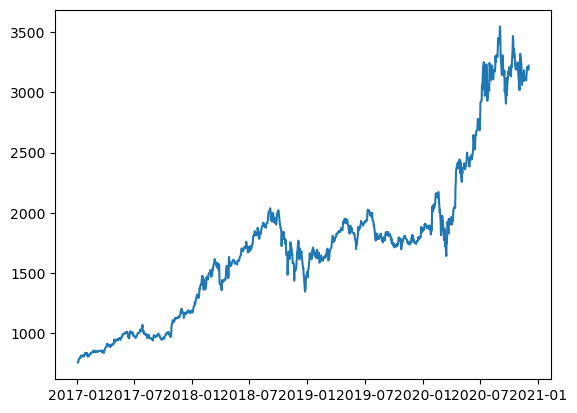

In [15]:
stocks.Show_Trend()

## Finding the correlation between prices of two different stocks

In [40]:
APPLE = StocksDataProcessing()
APPLE.ReadData("APPLE.csv", 1, {})
APPLE.Correlation(stocks.ReadData("AMAZON.csv", 1, {}))

0.929432373427345